In [7]:
from collections import Counter
from IPython.core.display import HTML, display 
from scipy.sparse import hstack
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from folium.plugins import MarkerCluster
import folium
import sys
import csv
import string
import warnings
import re
import os
import seaborn as sns
%matplotlib inline

Processing data. Please wait.

Question 1



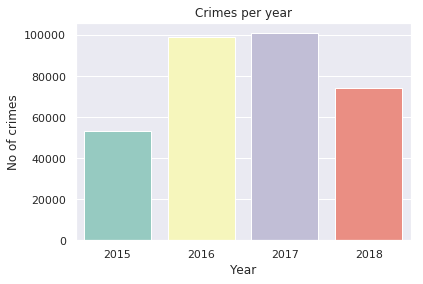

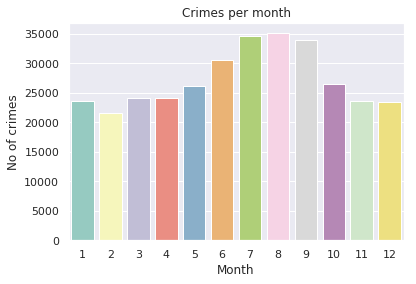

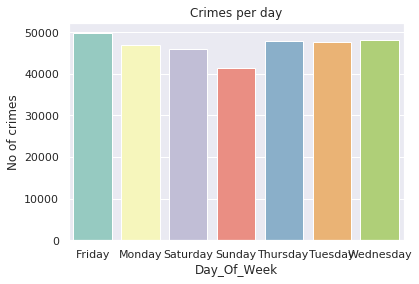

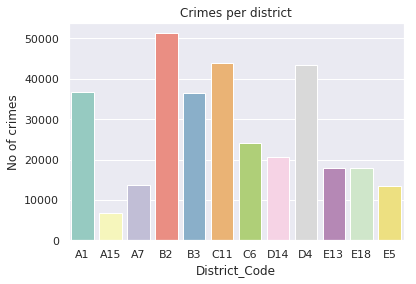


Question 2

2.1 The most shootings (number included) happened during the year: 2017 (371)
2.2 The most shootings (number included) have happened in the district: B2 (352)

Question 3

Most crimes have happened in day time.

Question 4

The most common crime during day-time is (number of appearences included): Motor Vehicle Accident Response (21852)

Question 5



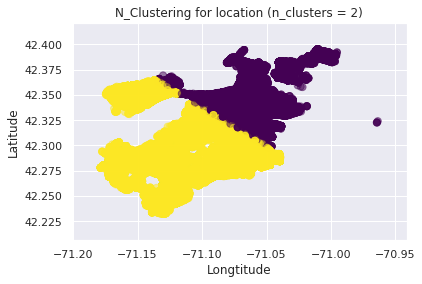

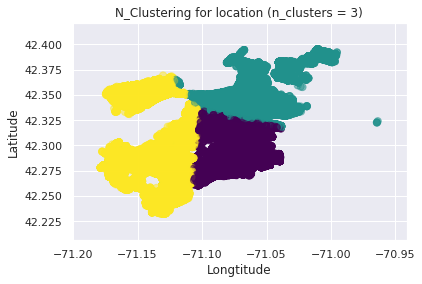

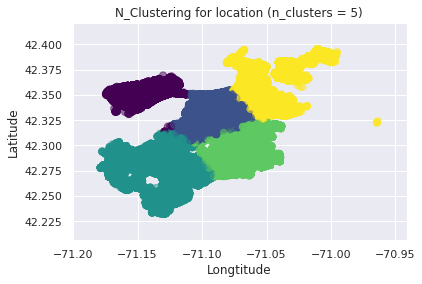

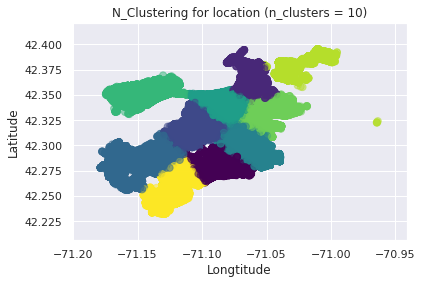

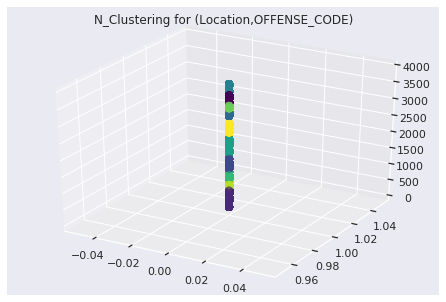

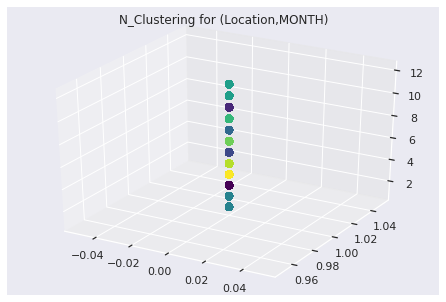


Bonus Question

End of Project 2


In [9]:
if __name__== "__main__":
	print("Processing data. Please wait.")

	pd.options.display.max_colwidth = 900

	#read the given *.csv file in order to create a dataframe for crime-data
	df = pd.read_csv('crime.csv', engine = 'python', escapechar = "\\")
	
	#drop columns that are useless
	df = df.drop(['INCIDENT_NUMBER', 'OFFENSE_DESCRIPTION', 'REPORTING_AREA', 'OCCURRED_ON_DATE', 'UCR_PART', 'STREET'], axis = 1)
	
	#prepare the subset for Bonus Question
	dfDrugs = df.loc[df['OFFENSE_CODE_GROUP'] == 'Drug Violation']
	dfDrugs = dfDrugs.drop(['OFFENSE_CODE_GROUP', 'OFFENSE_CODE', 'DISTRICT', 'SHOOTING', 'YEAR', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'Location'], axis = 1)
	dfDrugs = dfDrugs.dropna()

	#fill all NaN fields with a specific character
	df = df.fillna('N')

	#Question1
	print("\nQuestion 1\n")
	#group given data by year, month, day and district for the first part of the question
	dfYear = df.groupby('YEAR').size()
	years = df['YEAR'].sort_values().unique()
	
	dfMonth = df.groupby('MONTH').size()
	months = df['MONTH'].sort_values().unique()
	
	dfDay = df.groupby('DAY_OF_WEEK').size()
	days = df['DAY_OF_WEEK'].sort_values().unique()
	
	dfDistrict1 = df.loc[df['DISTRICT'] != 'N']
	dfDistrict = dfDistrict1.groupby('DISTRICT').size()
	districts = dfDistrict1['DISTRICT'].sort_values().unique()	

	#generate the wanted plots
	sns.set(style="darkgrid")
	colorCollection = sns.color_palette("Set3")
	
	plt.title("Crimes per year") 
	plt.xlabel('Year')
	plt.ylabel('No of crimes')
	ax = sns.barplot(x = years, y = dfYear, data = df, palette = colorCollection)
	plt.show()

	plt.title("Crimes per month") 
	plt.xlabel('Month')
	plt.ylabel('No of crimes')
	ax = sns.barplot(x = months, y = dfMonth, data = df, palette = colorCollection)
	plt.show()

	plt.title("Crimes per day") 
	plt.xlabel('Day_Of_Week')
	plt.ylabel('No of crimes')
	ax = sns.barplot(x = days, y = dfDay, data = df, palette = colorCollection)
	plt.show()

	plt.title("Crimes per district") 
	plt.xlabel('District_Code')
	plt.ylabel('No of crimes')
	ax = sns.barplot(x = districts, y = dfDistrict, data = df, palette = colorCollection)
	plt.show()

	#Question2
	print("\nQuestion 2\n")
	#keep only the rows that indicate that shootings have taken place
	dfShooting = df.loc[df['SHOOTING'] == 'Y']
	
	#group the previous results by year in order to answer the question 
	dfSY = dfShooting.groupby('YEAR').size()
	res = dfSY.sort_values(ascending=False).head(1)
	resList = res.to_string().split()
	print("2.1 The most shootings (number included) happened during the year: "+ resList[1] + " (" + resList[2] + ")")

	#group the previous results by district in order to answer the question
	dfSD = dfShooting.groupby('DISTRICT').size()
	#sort the results and keep the top-1
	res = dfSD.sort_values(ascending=False).head(1)
	resList = res.to_string().split()
	print("2.2 The most shootings (number included) have happened in the district: "+ resList[1] + " (" + resList[2] + ")")

	#Question3--->part1
	print("\nQuestion 3\n")
	#starting with an empty list where the new data will be stored in order to create the extra column
	timeOfDay = []

	#for each row of the current data
	for row in df['HOUR']:
		#decide if the crime has taken place during either day or night and fill the list with the propriate value
		if row > 17 or row < 7:
			timeOfDay.append('Night')
		else:
			timeOfDay.append('Day')
	
	#add the new columns to our dataframe
	df['TIME_OF_DAY'] = timeOfDay

	#Question3--->part2
	#group the initial dataframe by time-of-day when the crime happened
	dfTD = df.groupby('TIME_OF_DAY').size()

	#keep the results in an array in order to compare them
	res = np.array(dfTD)
	#check which one is larger and answer the question
	if res[0] > res[1]:
		print("Most crimes have happened in day time.")
	else:
		print("Most crimes have happened in night time.")

	#Question4
	print("\nQuestion 4\n")
	#keep only the rows of day-time crimes
	dfTD1 = df.loc[df['TIME_OF_DAY'] == 'Day']
	#group the previous results by OFFENSE_CODE_GROUP in order to answer the question
	dfOGC = dfTD1.groupby('OFFENSE_CODE_GROUP').size()
	#sort the results and keep the top-1
	res = dfOGC.sort_values(ascending=False).head(1)
	resList = res.to_string().split('\n')
	resList = resList[1].split()
	crimeDesc = str()
	counter = 0
	for i in resList:
		if counter == len(resList) - 1:
			counter = i
			break
		crimeDesc = crimeDesc + i + " "
		counter+=1
	print("The most common crime during day-time is (number of appearences included): "+ crimeDesc + "(" + counter + ")")

	#Question5
	print("\nQuestion 5\n")
	#replace NaN values in Lat, Long columns
	dfCoordinates = df[['Lat','Long']].replace('N', 0.0)
	dfCoordinates = dfCoordinates.loc[(dfCoordinates['Lat'] > 40) & (dfCoordinates['Long'] < -60)]

	#use KMeans for 2, 3, 5, 10 clusters
	km = KMeans(n_clusters = 2)
	kmeans = km.fit(dfCoordinates)
	predict = km.predict(dfCoordinates)
	
	plt.title("N_Clustering for location (n_clusters = 2)") 
	plt.xlabel('Longtitude')
	plt.ylabel('Latitude')
	plt.scatter(dfCoordinates['Long'], dfCoordinates['Lat'], c= kmeans.labels_.astype(float), s=50, alpha=0.5, cmap="viridis")
	plt.show()

	km = KMeans(n_clusters = 3)
	kmeans = km.fit(dfCoordinates)
	predict = km.predict(dfCoordinates)

	plt.title("N_Clustering for location (n_clusters = 3)") 
	plt.xlabel('Longtitude')
	plt.ylabel('Latitude')
	plt.scatter(dfCoordinates['Long'], dfCoordinates['Lat'], c= kmeans.labels_.astype(float), s=50, alpha=0.5, cmap="viridis")
	plt.show()

	km = KMeans(n_clusters = 5)
	kmeans = km.fit(dfCoordinates)
	predict = km.predict(dfCoordinates)

	plt.title("N_Clustering for location (n_clusters = 5)") 
	plt.xlabel('Longtitude')
	plt.ylabel('Latitude')
	plt.scatter(dfCoordinates['Long'], dfCoordinates['Lat'], c= kmeans.labels_.astype(float), s=50, alpha=0.5, cmap="viridis")
	plt.show()

	km = KMeans(n_clusters = 10)
	kmeans = km.fit(dfCoordinates)
	predict = km.predict(dfCoordinates)

	plt.title("N_Clustering for location (n_clusters = 10)") 
	plt.xlabel('Longtitude')
	plt.ylabel('Latitude')
	plt.scatter(dfCoordinates['Long'], dfCoordinates['Lat'], c= kmeans.labels_.astype(float), s=50, alpha=0.5, cmap="viridis")
	plt.show()


	#clean the Location from symbols and split to Lat, Long
	df['LocA'], df['LocB'] = df['Location'].str.strip('()').str.split(', ', expand=True)

	#keep just the needed columns
	dfLocOC = df[['LocA', 'LocB', 'OFFENSE_CODE']]

	#use KMeans for 10 clusters
	km = KMeans(n_clusters = 10)
	kmeans = km.fit(dfLocOC)
	predict = km.predict(dfLocOC)

	fig = plt.figure()
	ax = Axes3D(fig)
	ax.scatter(dfLocOC['LocA'], dfLocOC['LocB'], dfLocOC['OFFENSE_CODE'], c= kmeans.labels_.astype(float), s=50, alpha=0.5, cmap="viridis")
	
	plt.title("N_Clustering for (Location,OFFENSE_CODE)") 
	plt.show()
	
	dfLocMonth = df[['LocA', 'LocB' , 'MONTH']]
	km = KMeans(n_clusters = 10)
	kmeans = km.fit(dfLocMonth)
	predict = km.predict(dfLocMonth)

	fig = plt.figure()
	ax = Axes3D(fig)
	ax.scatter(dfLocMonth['LocA'], dfLocMonth['LocB'], dfLocMonth['MONTH'], c= kmeans.labels_.astype(float), s=50, alpha=0.5, cmap="viridis")
	
	plt.title("N_Clustering for (Location,MONTH)") 
	plt.show()

	#Bonus Question
	print("\nBonus Question\n")
	#separately keep the coordinates of Boston
	BST_COORDINATES = (42.3600825, -71.0588801)
	#initialize the map to BST
	bstMap = folium.Map(location=BST_COORDINATES, zoom_start=12, tiles='Cartodb Positron')
	mc = MarkerCluster().add_to(bstMap)

	#keep a list of the wanted locations
	locations = dfDrugs[['Lat','Long']]
	locationlist = locations.values.tolist()

	#for each location add a marker to the map and use add_child to display the results in groups
	for k in range(len(locationlist)):
		# if locationlist[k] == [-1.0, -1.0]:
		# 	continue
		marker = folium.Marker(location=locationlist[k])
		popup = 'location:{}'.format(locationlist[k])
		folium.Popup(popup).add_to(marker)
		mc.add_child(marker)
	
	#update the initial map	
	mc.add_to(bstMap)


	#folium.LayerControl().add_to(bstMap)
	iframe = bstMap._repr_html_()
	bstMap.save('boston.html')
	print("End of Project 2")

In [ ]:
Ερώτημα 1:
    Στο ερώτημα 1 παρουσιάζονται γραφικά οι συναρτήσεις (Εγκλήμα, Έτος), (Έγκλημα, Μήνας), (Έγκλημα, Ημέρα) και 
    (Έγκλημα, Περιοχή), με τη χρήση ομαδοποίησης μέσω της συνάρτησης groupby. 
Ερώτημα 2:
    Αρχικά απομονώνονται οι γραμμές του αρχείου στις οποίες η στήλη Shootings έχει την τιμή 'Y' και εν συνεχεία
    γίνονται οι ομαδοποιήσεις με βάση την ζητούμενη στήλη για κάθε σκέλος του ερωτήματος, ταξινομούνται σε φθίνουσα
    σειρά και παρουσιάζεται η απάντηση στο ερώτημα.
Ερώτημα 3:
    Για κάθε γραμμή των δεδομένων, ανάλογα με την τιμή της στήλης HOUR και το κριτήριο της εκφώνησης, επιλέγεται εάν
    πρόκειται για έγκλημα που έλαβε χώρα πρωινή ή απογευματινή ώρα και προστίθεται στα δεδομένα το αποτέλεσμα. Έπειτα
    γίνεται groupby με την νέα στήλη και ανάλογα με τις αντίστοιχες τιμές, απαντάται το ερώτημα.
Ερώτημα 4:
    Αρχικά κρατώνται τα εγκλήματα που γίνονται την ημέρα (τις μικρές ώρες), ομαδοποιούνται με βάση το OFFENSE_CODE_GROUP
    και μετά από φθίνουσα ταξινόμηση, επιλέγεται το συχνότερο.
Ερώτημα 5: 
    Καθ` υπόδειξη της κας Κολοβού, η δημιουργία των γραφημάτων με clusters παρουσιάζεται με 2, 3, 5, 10 clusters 
    για το πρώτο ερώτημα και με 10 clusters για τα υπόλοιπα 2. Για τις τελευταίες 2 περιπτώσεις χρησιμοποιείται 
    τρισδιάστατος σχεδιασμός για την απεικόνιση.
Bonus Ερώτημα: 
    Αρχικά, τα δεδομένα υφίστανται επεξεργασία με τέτοιο τρόπο, ώστε να απομονώνονται οι στήλες που αφορούν εγκλήματα
    της ζητούμενης κατηγορίας και εν συνεχεία διατηρείται μόνο η τοποθεσία τους (γεωγραφικό μήκος/πλάτος), η οποία 
    μετατρέπεται σε λίστα. Με τον τρόπο αυτό και με τη χρήση της βιβλιοθήκης folium, αναπαρίσταται γραφικά ο χάρτης 
    της Βοστώνης και με τη βοηθεία του MarkerCluster plugin τοποθετούνται counters ανα περιοχή που υποδεικνύουν το 
    πλήθος εμφανίσεων του ζητούμενου εγκλήματος.